<a href="https://colab.research.google.com/github/juanferEspinosa/Graph-Analytics/blob/main/GfNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 5.7 MB 7.6 MB/s 


In [ ]:
import dgl
import dgl.function as fn
from dgl import DGLGraph
from dgl.data import CoraGraphDataset, CiteseerGraphDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR,StepLR

import numpy as np
import pandas as pd
import scipy.sparse as sp
import time, math
import matplotlib.pyplot as plt
import sys
import itertools
from time import perf_counter

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
def load(data):
  if data == 'cora':
    dataset = CoraGraphDataset()
  elif data == 'citeseer':
    dataset = CiteseerGraphDataset()

  g = dataset[0]
  features = g.ndata['feat']
  labels = g.ndata['label']
  train_mask = g.ndata['train_mask']
  val_mask = g.ndata['val_mask']
  test_mask = g.ndata['test_mask']
  num_nodes = g.num_nodes()
  num_edges = g.num_edges()
  n_classes = dataset.num_classes
  return g, features, labels, train_mask, val_mask, test_mask, num_nodes, num_edges, n_classes

g, features, labels, train_mask, val_mask, test_mask, num_nodes, num_edges, n_classes = load('citeseer')

Extracting file to /root/.dgl/citeseer


/usr/local/lib/python3.7/dist-packages/dgl/data/citation_graph.py:275: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
train_split = g.ndata['train_mask'].int().sum().item()
val_split = g.ndata['val_mask'].int().sum().item()
test_split = g.ndata['test_mask'].int().sum().item()

In [ ]:
def sgc_precompute(features, g, degree):
  g = dgl.remove_self_loop(g)
  #g = dgl.add_self_loop(g)
  t = perf_counter()
  #t = time.time()
  for i in range(degree):
      features = torch.spmm(g.adj(), features)
  precompute_time = perf_counter()-t
  #precompute_time = time.time()-t
  return features, precompute_time

def normalizemx(mx):
  """Normalization for Scattering GCN"""
  degs = g.in_degrees().float()
  norm = torch.pow(degs, -1)
  norm = torch.diag(norm)
  print(norm.shape)
  print(features.shape)
  mx = torch.spmm(norm, mx)
  return mx

def evaluate(model, g, features, labels, mask):
  model.eval()
  with torch.no_grad():
      logits = model(features)
      logits = logits[mask]
      labels = labels[mask]
      _, indices = torch.max(logits, dim=1)
      correct = torch.sum(indices == labels)
      return correct.item() * 1.0 / len(labels)


In [ ]:
features = normalizemx(features)
features, aug_time = sgc_precompute(features, g, 3)


torch.Size([3327, 3327])
torch.Size([3327, 3703])


In [ ]:
class MLP(nn.Module):
  """
  A Simple two layers MLP to make SGC a bit better.
  """
  def __init__(self, in_feats, h_feats, num_classes, dp=0.2):
    super(MLP, self).__init__()
    self.W1 = nn.Linear(in_feats, h_feats)
    self.W2 = nn.Linear(h_feats, num_classes)
    self.dp = dp
    self.act = nn.PReLU()
    self.num_class = num_classes

  def forward(self, x):
    x = self.act(self.W1(x))
    x = nn.Dropout(p=self.dp)(x)
    return self.W2(x)

model = MLP(features.size(1), 16, n_classes)

In [ ]:
def train(g, model, nfeat, epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  best_val_acc = 0
  best_test_acc = 0
  loss_epoch = []
  accTest_epoch = []
  dur = []
  for e in range(epochs):
    if e> 3:
      #t0 = time.time()
      t0 = perf_counter()
    # Forward
    logits = model(features)

    # Compute prediction
    pred = logits.argmax(1)

    # Compute loss
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    loss_epoch.append(loss.detach().item())

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
    accTest_epoch.append(test_acc.detach().item())

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e > 3:
      #dur.append(time.time() - t0)
      dur.append(perf_counter() - t0)

    if e % 5 == 0:
        print('In epoch {} | loss: {:.3f} | val acc: {:.3f} | (best {:.3f}) | test acc: {:.3f} | (best {:.3f}) | Time(s) {:.4f}'.format(
            e, loss.item(), val_acc, best_val_acc, test_acc, best_test_acc, np.mean(dur)))
  test_accuracy = evaluate(model, g, features, labels, test_mask)
  print()
  print('---------- + ---------- ')
  print(test_accuracy)
  print('---------- + ---------- ')
  return loss_epoch, accTest_epoch, test_acc.detach().item(), best_test_acc.detach().item(), np.mean(dur)

In [ ]:
def run(runs, g, model, features, epochs):
  test_acc_gl = []
  best_test_acc = []
  losses = []
  accTests = []
  exec_ti = []
  i = 0
  for i in range(runs):
    i += 1
    print()
    print('---------- + ---------- ')
    print("Results for run {}.".format(i))
    print('---------- + ---------- ','\n')
    loss_epoch, accTest_epoch, test_acc, best_acc, time_s = train(g, model, features, epochs)
    test_acc_gl.append(test_acc)
    best_test_acc.append(best_acc)
    # Append all losses for plotting purpose
    losses.append(loss_epoch)
    accTests.append(accTest_epoch)
    exec_ti.append(time_s)

  loss_all = np.array(losses)
  accTest_all = np.array(accTests)
  return loss_all, accTest_all, test_acc_gl, best_test_acc, exec_ti, i

In [ ]:
loss_all, accTest_all, test_acc_gl, best_test_acc, times, i = run(5, g, model, features, epochs=201)


---------- + ---------- 
Results for run 1.
---------- + ----------  

In epoch 0 | loss: 1.800 | val acc: 0.142 | (best 0.142) | test acc: 0.157 | (best 0.157) | Time(s) nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In epoch 5 | loss: 1.477 | val acc: 0.362 | (best 0.362) | test acc: 0.364 | (best 0.364) | Time(s) 0.0248
In epoch 10 | loss: 1.248 | val acc: 0.470 | (best 0.470) | test acc: 0.473 | (best 0.473) | Time(s) 0.0265
In epoch 15 | loss: 1.021 | val acc: 0.520 | (best 0.520) | test acc: 0.512 | (best 0.512) | Time(s) 0.0265
In epoch 20 | loss: 0.822 | val acc: 0.528 | (best 0.532) | test acc: 0.518 | (best 0.513) | Time(s) 0.0259
In epoch 25 | loss: 0.697 | val acc: 0.538 | (best 0.542) | test acc: 0.528 | (best 0.523) | Time(s) 0.0258
In epoch 30 | loss: 0.528 | val acc: 0.540 | (best 0.542) | test acc: 0.514 | (best 0.523) | Time(s) 0.0259
In epoch 35 | loss: 0.432 | val acc: 0.562 | (best 0.562) | test acc: 0.537 | (best 0.537) | Time(s) 0.0269
In epoch 40 | loss: 0.352 | val acc: 0.550 | (best 0.562) | test acc: 0.525 | (best 0.537) | Time(s) 0.0269
In epoch 45 | loss: 0.304 | val acc: 0.564 | (best 0.564) | test acc: 0.549 | (best 0.556) | Time(s) 0.0269
In epoch 50 | loss: 0.236 | v

In [ ]:
print('Test accuracy for {} runs:'.format(i),test_acc_gl)
print('Best test accuracy for {} runs:'.format(i),best_test_acc)

Test accuracy for 5 runs: [0.5680000185966492, 0.5789999961853027, 0.546999990940094, 0.5320000052452087, 0.5410000085830688]
Best test accuracy for 5 runs: [0.5680000185966492, 0.574999988079071, 0.5580000281333923, 0.5590000152587891, 0.5820000171661377]


In [ ]:
df = pd.DataFrame([[np.mean(test_acc_gl),np.mean(best_test_acc),np.mean(times)]],columns=['Avg. Accuracy','Best Avg. Accuracy','Execution Time'])
df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

,Avg. Accuracy,Best Avg. Accuracy,Execution Time
0,0.553400,0.568400,0.035519


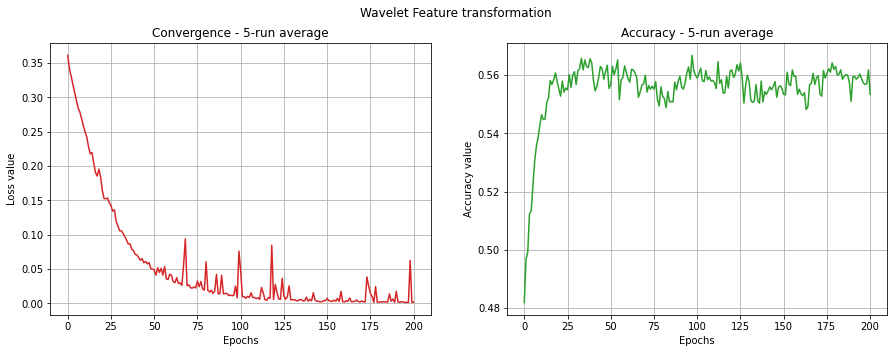

In [ ]:
avg_loss = np.mean(loss_all, 0)
avg_acctest = np.mean(accTest_all,0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Wavelet Feature transformation')
ax1.plot(range(len(avg_loss)), avg_loss, 'tab:red')
ax1.set(title='Convergence - {}-run average'.format(i), ylabel='Loss value', xlabel='Epochs')
ax1.grid(True)
ax2.plot(range(len(avg_acctest)), avg_acctest, 'tab:green')
ax2.set(title='Accuracy - {}-run average'.format(i), ylabel='Accuracy value', xlabel='Epochs')
ax2.grid(True)

In [ ]:
np.mean(times) + aug_time

0.1830604154446737